In [2]:
import os
import json

def get_data(folder_name):
    x = []
    y = []
    positions = []
    file_names = []

    for file in os.listdir(folder_name):
        if file.endswith(".txt"):
            file_name = os.path.join(folder_name, file[:-4])

            file_text = open(file_name + '.txt', encoding='utf8')
            try:
                file_truth = open(file_name + '.truth', encoding='utf8')

                try:
                    text = file_text.read()
                    truth = json.load(file_truth)
                    truth_changes = truth['changes']
                    truth_positions = truth['positions']

                    x.append(text)
                    y.append(truth_changes)
                    positions.append(truth_positions)
                    file_names.append(file[:-4])
                finally:
                    file_truth.close()
            finally:
                file_text.close()

    return x, y, positions, file_names

In [3]:
from nltk.tokenize import sent_tokenize, word_tokenize
def custom_sent_tokenize(text):
    sentences = []
    paragraphs = [p for p in text.split('\n') if p]
    for paragraph in paragraphs:
        sentences.extend(sent_tokenize(paragraph))
        
    return sentences

In [4]:
def segment_tokenize(text, n=10):
    segments = []
    sentences = custom_sent_tokenize(text)
    x = len(sentences)
    i = 0
    for i in range(0, x-x%n, n):
        segments.append(''.join(sentences[i:i+n]))
    segments.append(''.join(sentences[i:]))
    
    return segments

In [6]:
import pandas as pd

TRAINING_DIR = '../data/training'
FUNCTION_WORDS_FILE = '../data/external/function_words/source1.txt'

X, y, positions, file_names = get_data(
    TRAINING_DIR)
df = pd.DataFrame(data={'text': X, 'label': y, 'filename': file_names, 'pos':positions})
df['num_sent'] = [len(custom_sent_tokenize(d)) for d in df.text]
df['num_splits'] = [len(x) for x in df.pos]

with open(FUNCTION_WORDS_FILE) as f:
    function_words = f.read().splitlines()

In [7]:
len(function_words)

277

In [9]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
function_words_no_stop = set(function_words) - set(stop_words)

print(len(function_words_no_stop))

def only_function_words(text):
    result = ''
    words = word_tokenize(text.lower())
    for w in words:
        if w in function_words_no_stop:
            result=result+' '+ w
        
    return result

156


In [16]:
only_function_words(df.text[0])

' anyone last used rather used etc first behind even often since done often need also would sometimes could everything instead per around lot need also less per every many something etc anyone last used rather used still last something around might even done done need'

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import numpy as np

def word_vectors(data):
    vectors = []
    vect = TfidfVectorizer(max_features=20)
    vect.fit([only_function_words(d) for d in data])
    
    for d in data:
        segments = segment_tokenize(d)
        train_x = vect.transform([only_function_words(s) for s in segments]).toarray()
        vectors.append(np.std(train_x, axis=0))
    
    return vectors, vect.get_feature_names()

In [47]:
X, names = word_vectors(df.text)

In [48]:
X = np.array(X)

In [49]:
for i in range(len(names)):
    df[names[i]] = X[:,i]

In [50]:
from sklearn.feature_selection import SelectKBest, chi2
ch2 = SelectKBest(chi2, k=10)
X_train = ch2.fit_transform(X, df.label)
best = [names[i] for i in ch2.get_support(indices=True)]

In [51]:
best

['also',
 'even',
 'first',
 'however',
 'might',
 'one',
 'something',
 'used',
 'well',
 'would']

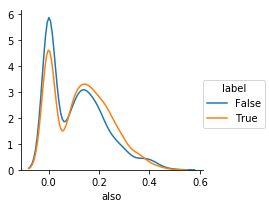

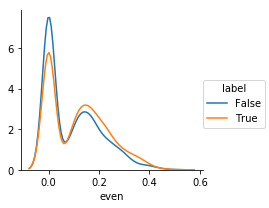

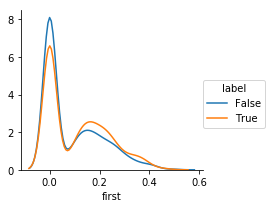

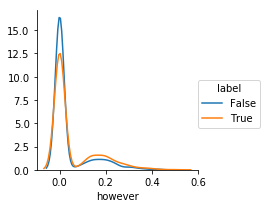

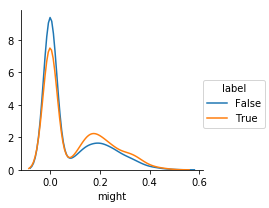

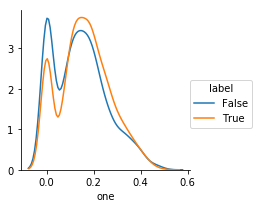

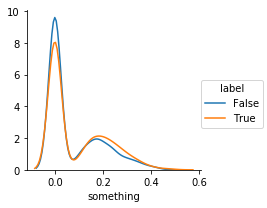

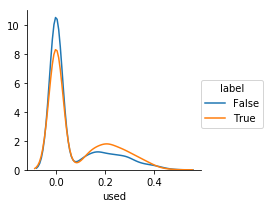

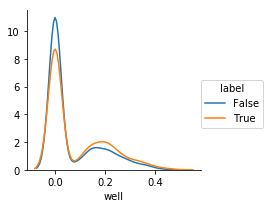

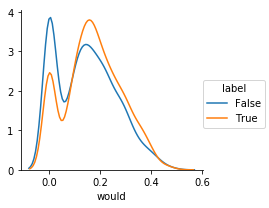

In [52]:
import seaborn as sns
for name in best:
    plt.figure()
    sns.FacetGrid(df, hue="label") \
       .map(sns.kdeplot, name) \
       .add_legend()